## Import Libraries and Data

In [21]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.feature_selection import f_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.graphics.gofplots import qqplot
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib
color_pal = sns.color_palette()

# Read the CSV file into Pandas DataFrame
data = pd.read_csv("Weather_data_2023_2024.csv", parse_dates=True, index_col="datetime")

## Data Exploration

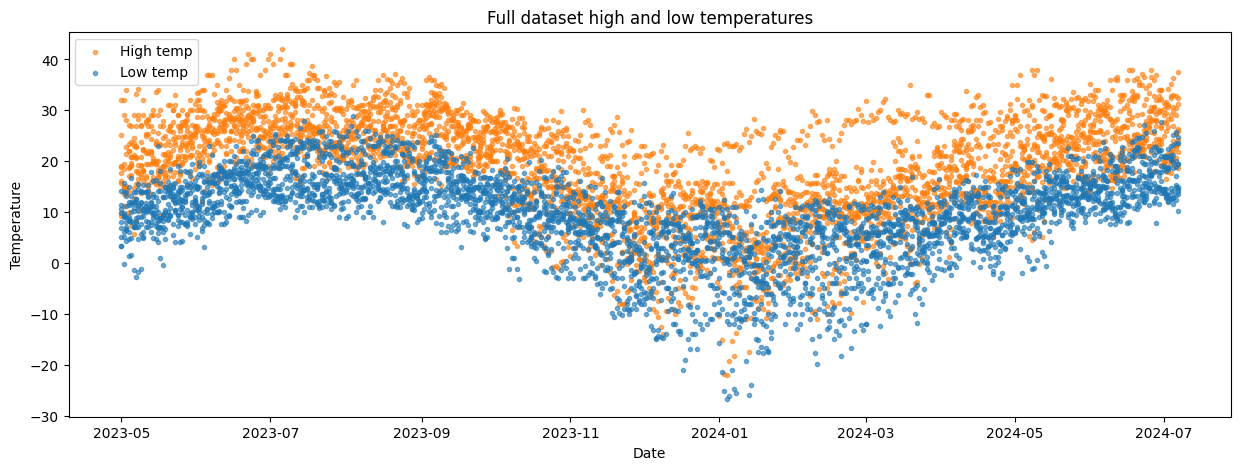

In [22]:
# Plot the tempmax and tempmin columns
fig, ax = plt.subplots(figsize=(15, 5))
plt.scatter(data.index, data['tempmax'], color=color_pal[1], label='High temp', alpha=0.6, marker='.')
plt.scatter(data.index, data['tempmin'], color=color_pal[0], label='Low temp', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [23]:
print(data.shape)
data.isnull().sum()

(3906, 27)


location             0
tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
sunrise              0
sunset               0
moonphase            0
conditions           0
description          0
icon                 0
stations            53
dtype: int64

In [24]:
data.duplicated().sum()

0

In [25]:
# Drop Columns of No Interest
df = data.drop(columns=['stations', 'icon', 'description', 'conditions', 'sunset', 'sunrise'])

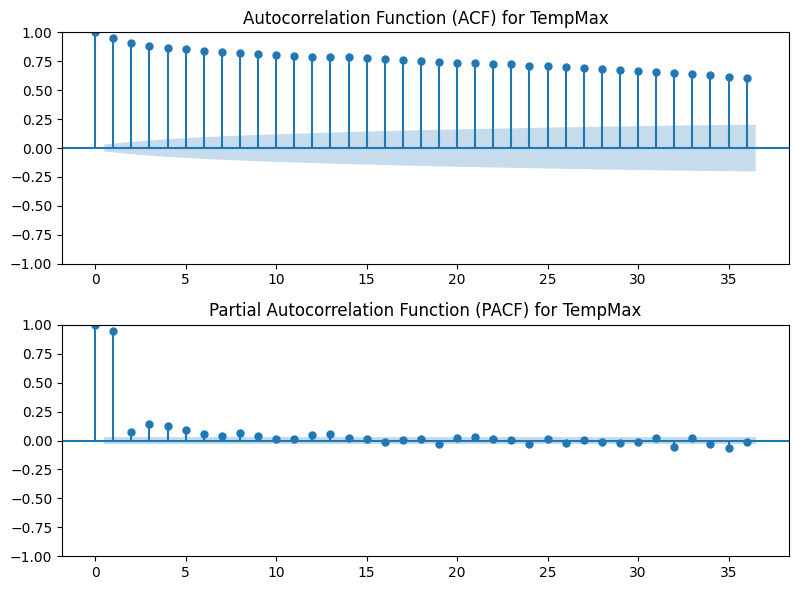

In [26]:
# Create a figure and subplots for ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Plot ACF
plot_acf(df['tempmax'], ax=ax[0])
ax[0].set_title('Autocorrelation Function (ACF) for TempMax')

# Plot PACF
plot_pacf(df['tempmax'], ax=ax[1])
ax[1].set_title('Partial Autocorrelation Function (PACF) for TempMax')

# Adjust layout
plt.tight_layout()
plt.show()

## Identify Key Factors/Feature Selection

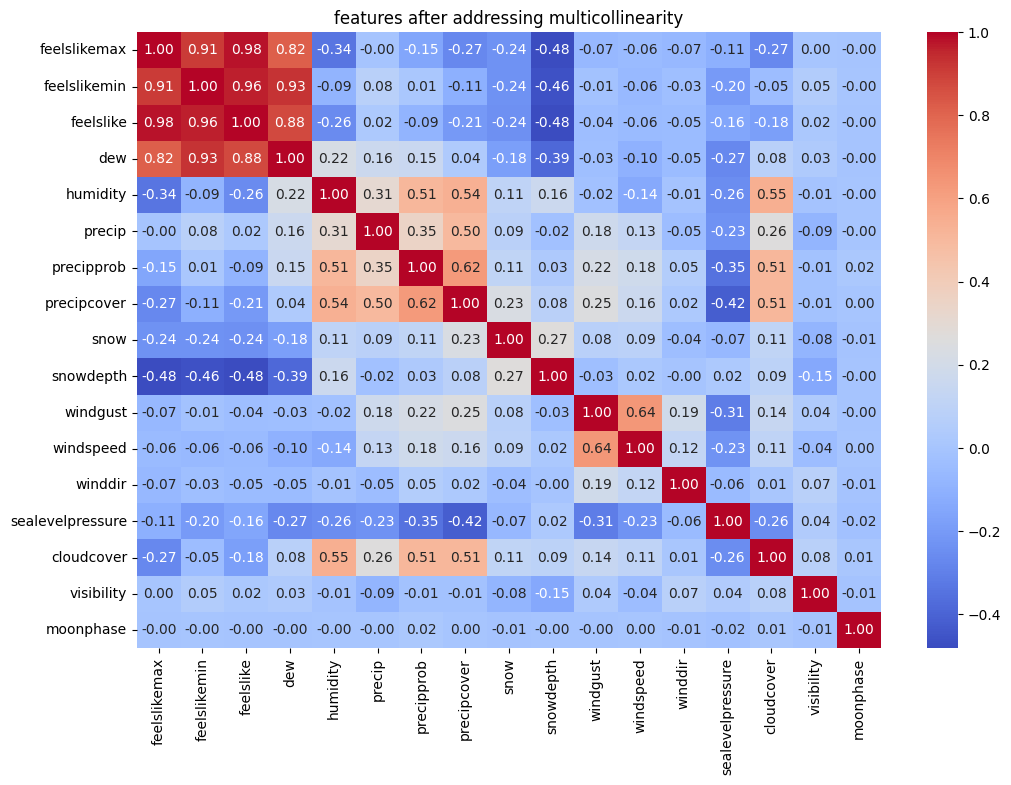

In [27]:
features = df[['feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']]

y_max = df['tempmax']
y_min = df['tempmin']

df = df.select_dtypes(include=['number'])
correlation_matrix = features.corr()
plt.figure(figsize=(12, 8))
plt.title("features after addressing multicollinearity")
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [66]:
# Define the DataFrame with combined highly correlated features
df['feelslike_combined'] = df[['feelslikemin', 'feelslikemax', 'feelslike']].mean(axis=1)
df['dew_humidity'] = df[['dew', 'humidity']].mean(axis=1)

# Recalculate the features DataFrame without the original features
features_combined_max = df[['feelslike_combined', 'dew_humidity', 'precip', 'snow', 'snowdepth', 'winddir',
                        'visibility', 'moonphase']]

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = features_combined_max.columns
vif_data["VIF"] = [variance_inflation_factor(features_combined_max.values, i) for i in range(features_combined_max.shape[1])]

# Display features with high VIF
print( vif_data.sort_values(by="VIF", ascending=False))

              feature       VIF
1        dew_humidity  9.966406
6          visibility  4.224376
5             winddir  4.095284
0  feelslike_combined  3.666799
7           moonphase  3.447316
4           snowdepth  1.398886
2              precip  1.250394
3                snow  1.120895


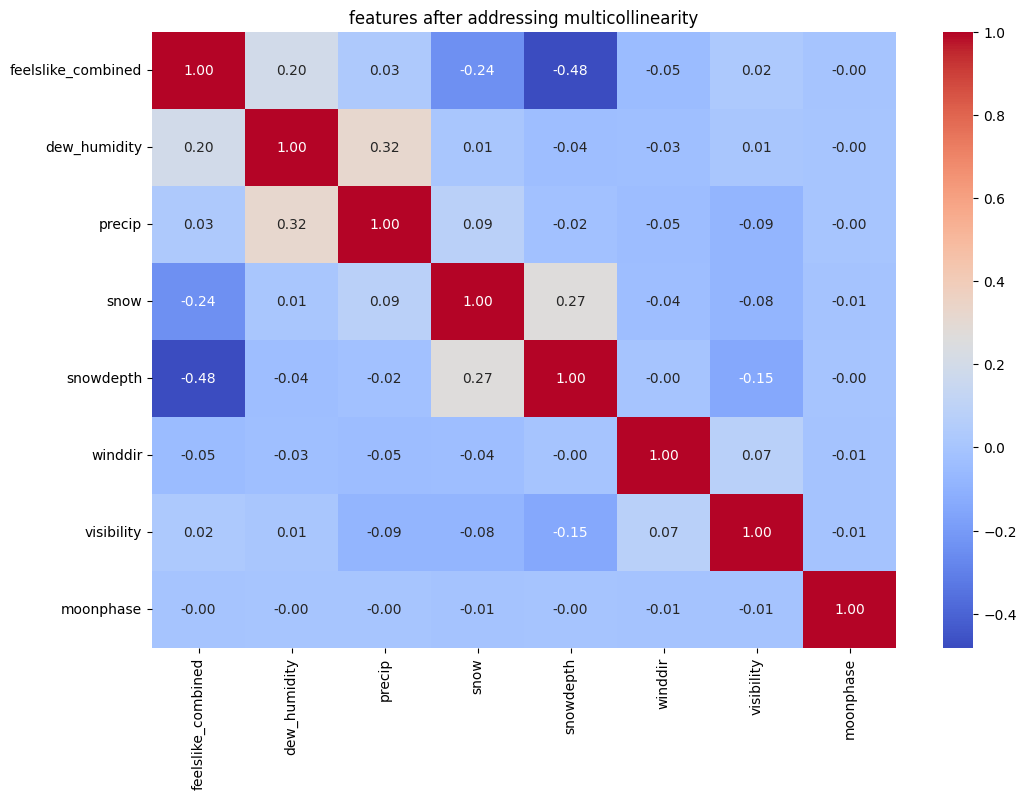

In [29]:
correlation_matrix = features_combined_max.corr()
plt.figure(figsize=(12, 8))
plt.title("features after addressing multicollinearity")
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

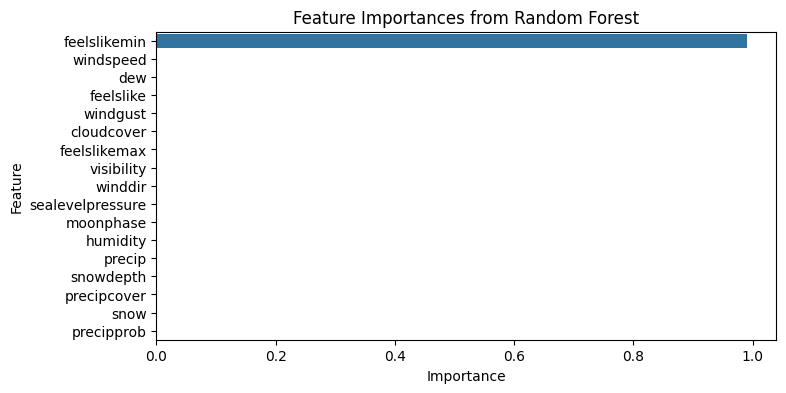

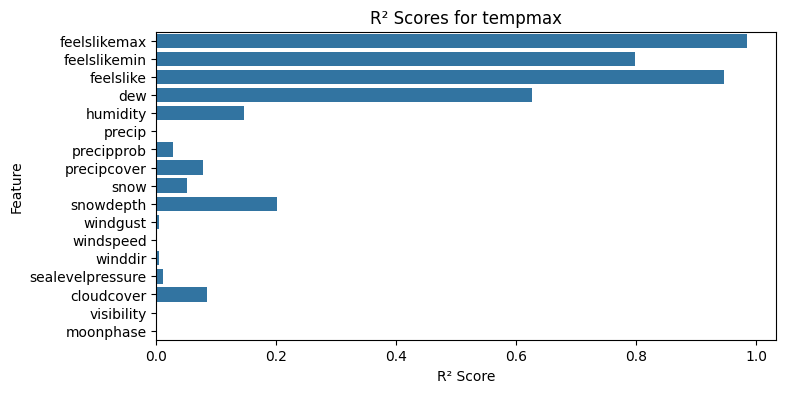

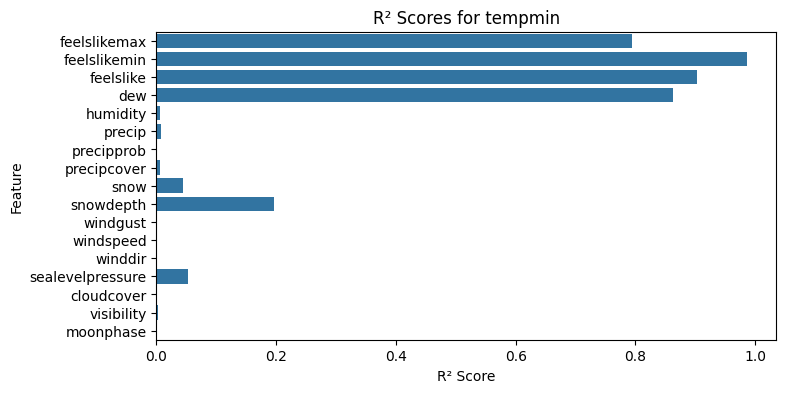

In [77]:
features = ['feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'moonphase']

X = df[features]
y_max = df['tempmax']
y_min = df['tempmin']

# Initialize and fit RandomForest for feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y_min)
importances = rf_model.feature_importances_

# Create DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Calculate R² for each feature using Ridge Regression
r2_scores_max = {}
r2_scores_min = {}

# Initialize Ridge model
ridge_model = Ridge()

for feature in features:
    X_feature = X[[feature]]

    # Fit and predict for tempmax
    ridge_model.fit(X_feature, y_max)
    y_pred_max = ridge_model.predict(X_feature)
    r2_scores_max[feature] = r2_score(y_max, y_pred_max)

    # Fit and predict for tempmin
    ridge_model.fit(X_feature, y_min)
    y_pred_min = ridge_model.predict(X_feature)
    r2_scores_min[feature] = r2_score(y_min, y_pred_min)

# Create DataFrame for R² scores
r2_scores_df_max = pd.DataFrame(list(r2_scores_max.items()), columns=['Feature', 'R² (tempmax)'])
r2_scores_df_min = pd.DataFrame(list(r2_scores_min.items()), columns=['Feature', 'R² (tempmin)'])

# Plot Feature Importances
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Plot R² scores for tempmax
plt.figure(figsize=(8, 4))
sns.barplot(x='R² (tempmax)', y='Feature', data=r2_scores_df_max)
plt.title('R² Scores for tempmax')
plt.xlabel('R² Score')
plt.ylabel('Feature')
plt.show()

# Plot R² scores for tempmin
plt.figure(figsize=(8, 4))
sns.barplot(x='R² (tempmin)', y='Feature', data=r2_scores_df_min)
plt.title('R² Scores for tempmin')
plt.xlabel('R² Score')
plt.ylabel('Feature')
plt.show()

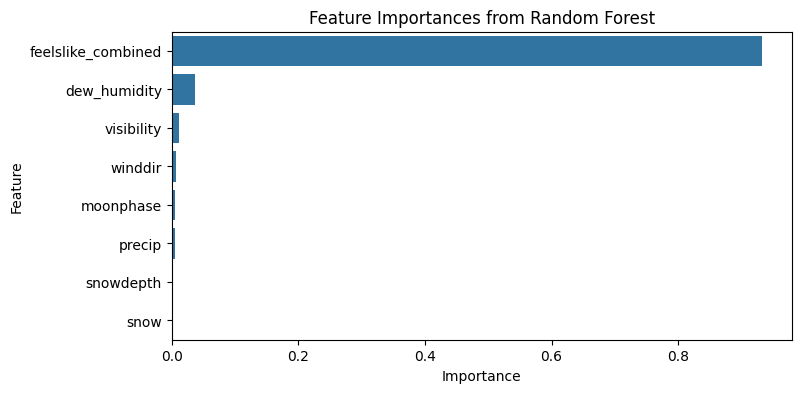

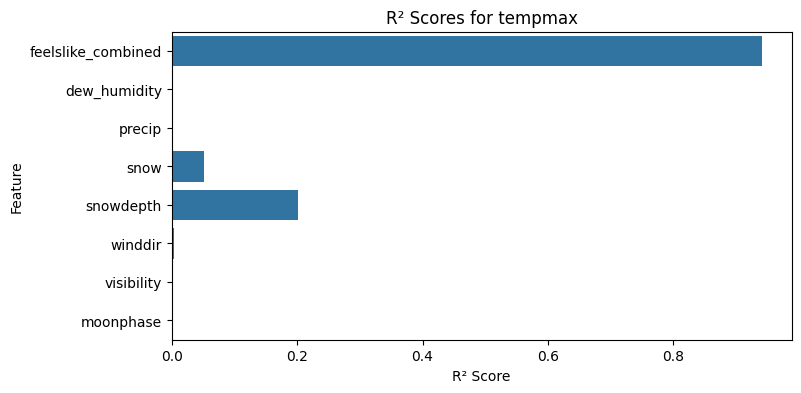

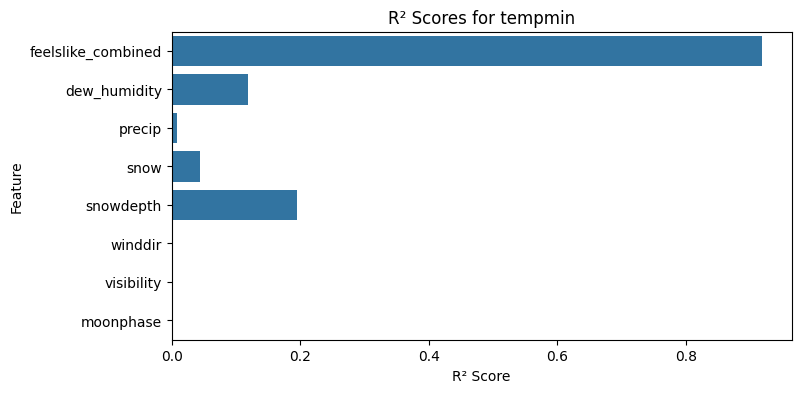

In [79]:
features = ['feelslike_combined', 'dew_humidity', 'precip', 'snow', 'snowdepth',
            'winddir', 'visibility', 'moonphase']

X = df[features]
y_max = df['tempmax']
y_min = df['tempmin']

# Initialize and fit RandomForest for feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X, y_min)
importances = rf_model.feature_importances_

# Create DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Calculate R² for each feature using Ridge Regression
r2_scores_max = {}
r2_scores_min = {}

# Initialize Ridge model
ridge_model = Ridge()

for feature in features:
    X_feature = X[[feature]]

    # Fit and predict for tempmax
    ridge_model.fit(X_feature, y_max)
    y_pred_max = ridge_model.predict(X_feature)
    r2_scores_max[feature] = r2_score(y_max, y_pred_max)

    # Fit and predict for tempmin
    ridge_model.fit(X_feature, y_min)
    y_pred_min = ridge_model.predict(X_feature)
    r2_scores_min[feature] = r2_score(y_min, y_pred_min)

# Create DataFrame for R² scores
r2_scores_df_max = pd.DataFrame(list(r2_scores_max.items()), columns=['Feature', 'R² (tempmax)'])
r2_scores_df_min = pd.DataFrame(list(r2_scores_min.items()), columns=['Feature', 'R² (tempmin)'])

# Plot Feature Importances
plt.figure(figsize=(8, 4))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Plot R² scores for tempmax
plt.figure(figsize=(8, 4))
sns.barplot(x='R² (tempmax)', y='Feature', data=r2_scores_df_max)
plt.title('R² Scores for tempmax')
plt.xlabel('R² Score')
plt.ylabel('Feature')
plt.show()

# Plot R² scores for tempmin
plt.figure(figsize=(8, 4))
sns.barplot(x='R² (tempmin)', y='Feature', data=r2_scores_df_min)
plt.title('R² Scores for tempmin')
plt.xlabel('R² Score')
plt.ylabel('Feature')
plt.show()

## Hypothesis
"A higher dew point likely predicts a higher temperature across locations, making dew point a reliable temperature predictor irrespective of geography."

## Train-Test Split
### Translate Hypothesis to Testable Statements/Validate Features

In [48]:
# Define target variables
y_max = df['tempmax']
y_min = df['tempmin']

# Define feature set with combined features
X = df[['feelslike_combined', 'dew_humidity', 'precip', 'snow', 'snowdepth',
        'winddir', 'visibility', 'moonphase']]

# Split training and testing data by dates
train = df.loc[df.index < '2024-03-01']
validate = df.loc[(df.index >= '2024-03-01') & (df.index < '2024-04-13')]
test = df.loc[df.index >= '2024-04-13']


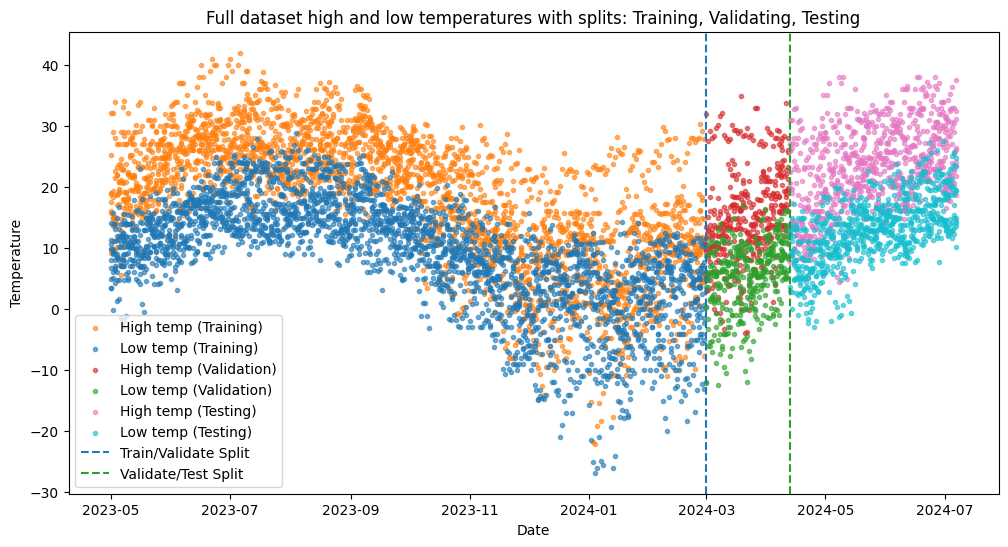

In [52]:
# Define split dates
train_end_date = pd.to_datetime('2024-03-01')
validate_end_date = pd.to_datetime('2024-04-13')
test_start_date = pd.to_datetime('2024-04-13')

# Split the data into before and after the split date
train = df.loc[df.index < train_end_date]
validate = df.loc[(df.index >= train_end_date) & (df.index < validate_end_date)]
test = df.loc[df.index >= test_start_date]

# Create the scatter plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the tempmax and tempmin columns for training data
plt.scatter(train.index, train['tempmax'], color=color_pal[1], label='High temp (Training)', alpha=0.6, marker='.')
plt.scatter(train.index, train['tempmin'], color=color_pal[0], label='Low temp (Training)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for validation data
plt.scatter(validate.index, validate['tempmax'], color=color_pal[3], label='High temp (Validation)', alpha=0.6, marker='.')
plt.scatter(validate.index, validate['tempmin'], color=color_pal[2], label='Low temp (Validation)', alpha=0.6, marker='.')

# Plot the tempmax and tempmin columns for testing data
plt.scatter(test.index, test['tempmax'], color=color_pal[6], label='High temp (Testing)', alpha=0.6, marker='.')
plt.scatter(test.index, test['tempmin'], color=color_pal[9], label='Low temp (Testing)', alpha=0.6, marker='.')

# Add titles and labels
plt.title('Full dataset high and low temperatures with splits: Training, Validating, Testing')
plt.xlabel('Date')
plt.ylabel('Temperature')

# Add vertical lines to mark the splits
ax.axvline(train_end_date, color=color_pal[0], ls='--', label='Train/Validate Split')
ax.axvline(validate_end_date, color=color_pal[2], ls='--', label='Validate/Test Split')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Define target variables
y_train_max = train['tempmax']
y_train_min = train['tempmin']
y_validate_max = validate['tempmax']
y_validate_min = validate['tempmin']
y_test_max = test['tempmax']
y_test_min = test['tempmin']

# Define feature sets
X_train = train[['feelslike_combined', 'dew_humidity', 'precip', 'snow', 'snowdepth', 'winddir', 'visibility', 'moonphase']]
X_validate = validate[['feelslike_combined', 'dew_humidity', 'precip', 'snow', 'snowdepth', 'winddir', 'visibility', 'moonphase']]
X_test = test[['feelslike_combined', 'dew_humidity', 'precip', 'snow', 'snowdepth', 'winddir', 'visibility', 'moonphase']]

##  Model Cross Validation

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "Support Vector Regression": SVR()
}

# Perform cross-validation and evaluate each model
for name, model in models.items():
    cv_scores = cross_val_score(model, X_train, y_train_max, cv=5, scoring='r2')
    print(f"{name} - Cross-Validated R²: {cv_scores.mean()}")

# Train the best model (replace RandomForestRegressor with the chosen model)
best_model = RandomForestRegressor(random_state=42)
best_model.fit(X_train, y_train_max)
y_pred_validate_max = best_model.predict(X_validate)
r2_validate_max = r2_score(y_validate_max, y_pred_validate_max)
print(f"Best Model Validation R²: {r2_validate_max}")


Linear Regression - Cross-Validated R²: 0.9638232160792398
Ridge Regression - Cross-Validated R²: 0.963823422242322
Lasso Regression - Cross-Validated R²: 0.9626569384925947
Random Forest - Cross-Validated R²: 0.9605521256159054
Gradient Boosting - Cross-Validated R²: 0.9628189229337739
Support Vector Regression - Cross-Validated R²: 0.753077718810853
Best Model Validation R²: 0.9381268787596166


## Model Training and Evaluation

In [62]:
# Function to evaluate a model
def evaluate_model(X_train, y_train, X_test, y_test, model_name):
    # Fit the model using statsmodels for detailed analysis
    X_train_sm = sm.add_constant(X_train)
    X_test_sm = sm.add_constant(X_test)
    model_sm = sm.OLS(y_train, X_train_sm).fit()

    # Predictions
    y_train_pred = model_sm.predict(X_train_sm)
    y_test_pred = model_sm.predict(X_test_sm)

    # Goodness of fit
    print(f"Model Summary for {model_name}:")
    print(model_sm.summary())

    # Error metrics
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f'Train RMSE for {model_name}: {train_rmse}, Test RMSE: {test_rmse}')
    print(f'Train MAE for {model_name}: {train_mae}, Test MAE: {test_mae}')
    print(f'Train R² for {model_name}: {train_r2}, Test R²: {test_r2}')

    # Residual analysis
    residuals = y_train - y_train_pred

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(y_train_pred, residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title(f'Residuals vs Predicted for {model_name}')

    plt.subplot(1, 2, 2)
    qqplot(residuals, line='s', ax=plt.gca())
    plt.title(f'Q-Q Plot of Residuals for {model_name}')

    plt.tight_layout()
    plt.show()

    # Multicollinearity
    vif_data = pd.DataFrame()
    vif_data['feature'] = X_train.columns
    vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
    print(f"VIF for {model_name}:\n", vif_data)

    # Autocorrelation
    sm.graphics.tsa.plot_acf(residuals, lags=40)
    plt.title(f'Autocorrelation of Residuals for {model_name}')
    plt.show()

In [60]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score

# Define the parameter values based on hyperparameter tuning
alpha_max = 0.1
alpha_min = 100.0

# Initialize and fit the Ridge Regression model for tempmax
ridge_model_max = Ridge(alpha=alpha_max)
ridge_model_max.fit(X_train, y_train_max)

# Make predictions on the test set for tempmax
y_pred_test_max = ridge_model_max.predict(X_test)

# Calculate R² for test set for tempmax
r2_test_max = r2_score(y_test_max, y_pred_test_max)
print(f"Ridge Regression Test R² for tempmax: {r2_test_max}")

# Initialize and fit the Ridge Regression model for tempmin
ridge_model_min = Ridge(alpha=alpha_min)
ridge_model_min.fit(X_train, y_train_min)

# Make predictions on the test set for tempmin
y_pred_test_min = ridge_model_min.predict(X_test)

# Calculate R² for test set for tempmin
r2_test_min = r2_score(y_test_min, y_pred_test_min)
print(f"Ridge Regression Test R² for tempmin: {r2_test_min}")



Ridge Regression Test R² for tempmax: 0.9349924043087633
Ridge Regression Test R² for tempmin: 0.8921671085031575


Model Summary for TempMax:
                            OLS Regression Results                            
Dep. Variable:                tempmax   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.970
Method:                 Least Squares   F-statistic:                 2.987e+04
Date:                Tue, 30 Jul 2024   Prob (F-statistic):               0.00
Time:                        17:06:37   Log-Likelihood:                -5509.9
No. Observations:                2745   AIC:                         1.103e+04
Df Residuals:                    2741   BIC:                         1.105e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const    

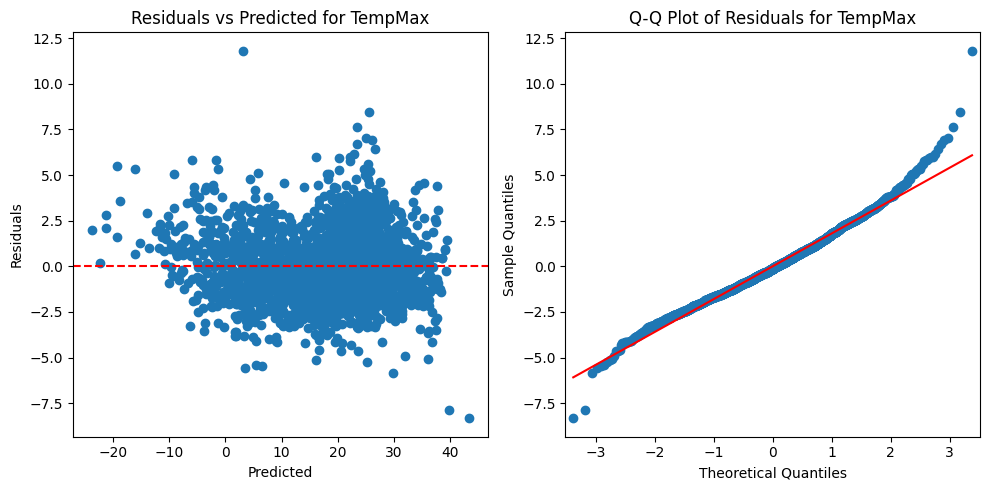

VIF for TempMax:
               feature       VIF
0  feelslike_combined  3.352191
1        dew_humidity  3.417790
2           snowdepth  1.396263


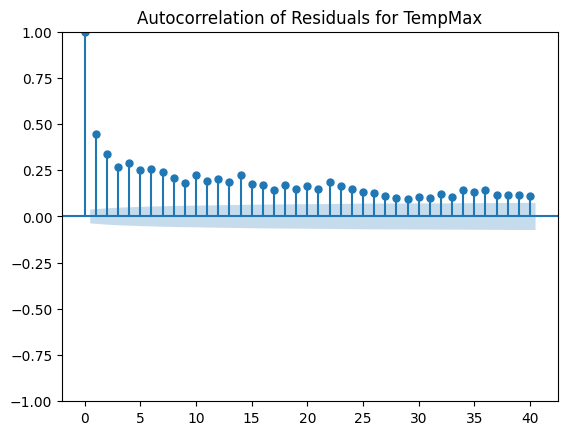

Model Summary for TempMin:
                            OLS Regression Results                            
Dep. Variable:                tempmin   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.950
Method:                 Least Squares   F-statistic:                 1.729e+04
Date:                Tue, 30 Jul 2024   Prob (F-statistic):               0.00
Time:                        17:06:38   Log-Likelihood:                -5775.9
No. Observations:                2745   AIC:                         1.156e+04
Df Residuals:                    2741   BIC:                         1.158e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const    

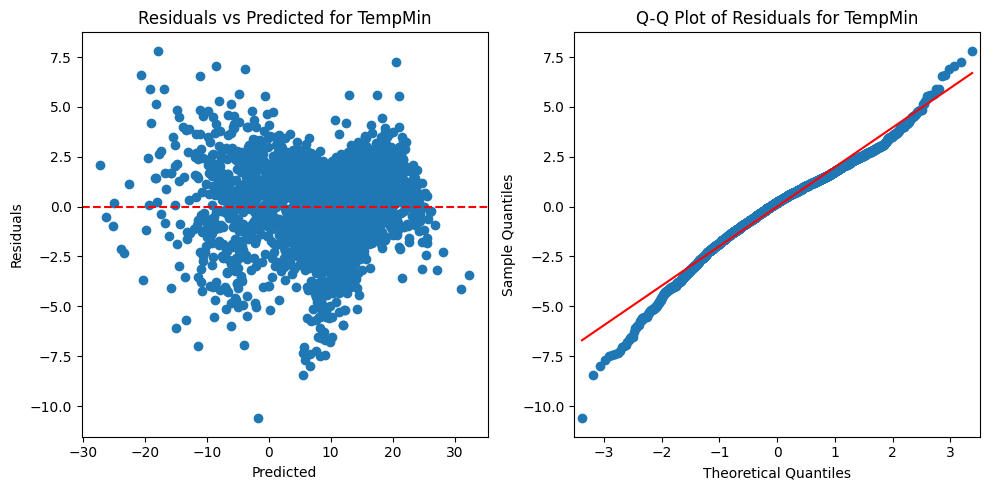

VIF for TempMin:
               feature       VIF
0  feelslike_combined  3.352191
1        dew_humidity  3.417790
2           snowdepth  1.396263


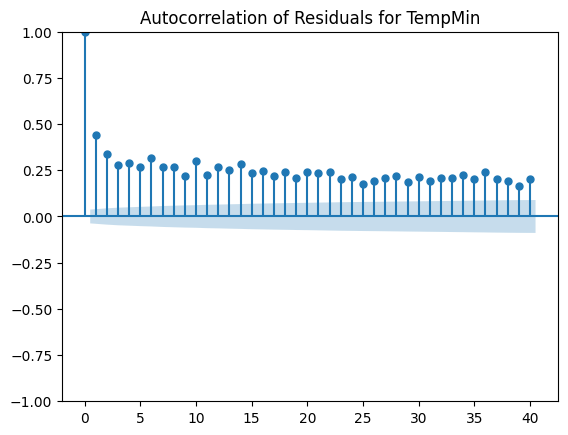

In [65]:
# Evaluate the Ridge models
evaluate_model(X_train, y_train_max, X_validate, y_validate_max, 'TempMax')
evaluate_model(X_train, y_train_min, X_validate, y_validate_min, 'TempMin')

In [55]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid for Ridge Regression
param_grid = {
    'alpha': [0.1, 1.0, 10.0, 100.0]
}

# Initialize Ridge model and GridSearchCV
ridge = Ridge()
grid_search_max = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_search_min = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')

# Fit GridSearchCV for tempmax
grid_search_max.fit(X_train, y_train_max)

# Fit GridSearchCV for tempmin
grid_search_min.fit(X_train, y_train_min)

# Print best parameters and best score for tempmax
print("Best Parameters for tempmax:", grid_search_max.best_params_)
print("Best Score for tempmax:", grid_search_max.best_score_)

# Print best parameters and best score for tempmin
print("Best Parameters for tempmin:", grid_search_min.best_params_)
print("Best Score for tempmin:", grid_search_min.best_score_)

# Use the best models
best_ridge_model_max = grid_search_max.best_estimator_
best_ridge_model_min = grid_search_min.best_estimator_


Best Parameters for tempmax: {'alpha': 0.1}
Best Score for tempmax: 0.9642960883090792
Best Parameters for tempmin: {'alpha': 100.0}
Best Score for tempmin: 0.9308954399359335


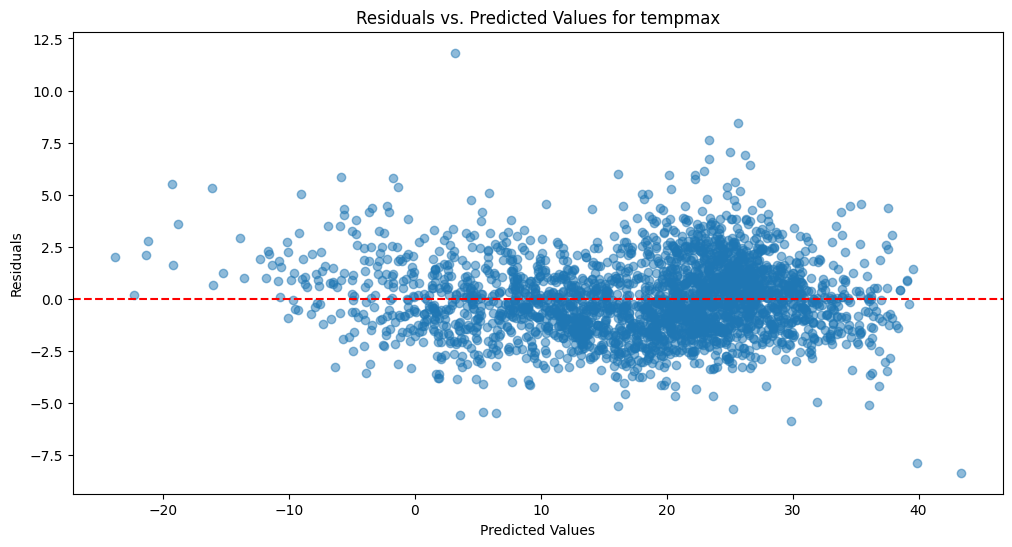

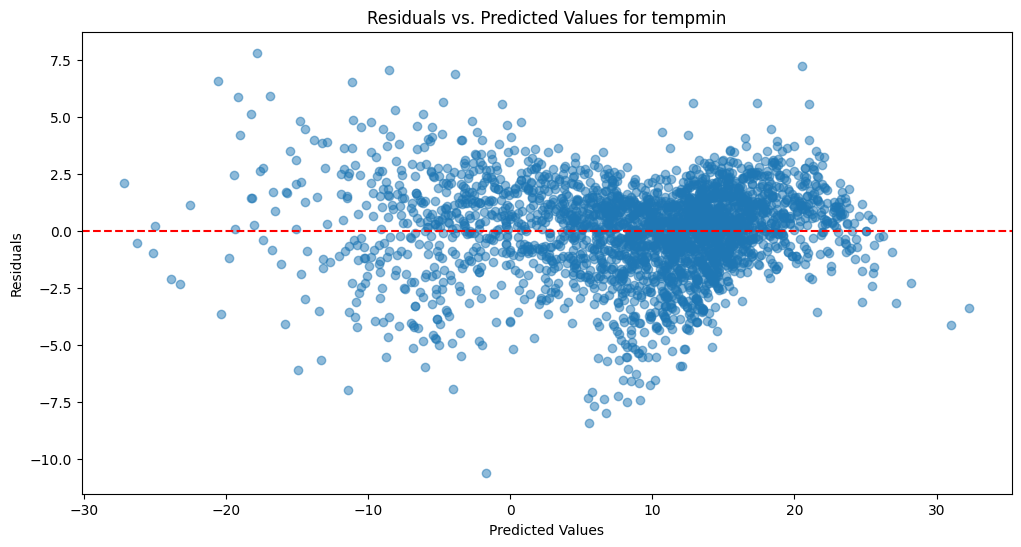

In [56]:
import matplotlib.pyplot as plt

# Predict on training set for tempmax
y_train_pred_max = best_ridge_model_max.predict(X_train)
residuals_max = y_train_max - y_train_pred_max

# Plot residuals for tempmax
plt.figure(figsize=(12, 6))
plt.scatter(y_train_pred_max, residuals_max, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values for tempmax')
plt.show()

# Predict on training set for tempmin
y_train_pred_min = best_ridge_model_min.predict(X_train)
residuals_min = y_train_min - y_train_pred_min

# Plot residuals for tempmin
plt.figure(figsize=(12, 6))
plt.scatter(y_train_pred_min, residuals_min, alpha=0.5)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values for tempmin')
plt.show()


In [58]:
# Feature importances for tempmax
importances_max = abs(best_ridge_model_max.coef_)
importance_df_max = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_max
}).sort_values(by='Importance', ascending=False)

print("Feature Importances from Ridge Regression for tempmax:")
print(importance_df_max)

# Feature importances for tempmin
importances_min = abs(best_ridge_model_min.coef_)
importance_df_min = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances_min
}).sort_values(by='Importance', ascending=False)

print("Feature Importances from Ridge Regression for tempmin:")
print(importance_df_min)



Feature Importances from Ridge Regression for tempmax:
              Feature  Importance
0  feelslike_combined    0.985098
1        dew_humidity    0.166455
2           snowdepth    0.051950
Feature Importances from Ridge Regression for tempmin:
              Feature  Importance
0  feelslike_combined    0.754483
1        dew_humidity    0.140095
2           snowdepth    0.016559


# Next steps:
- Seperate tempmax and tempmin features?
- Find best hyperparameters for both tempmax and tempmin models
- Plot learning curve and ensure no overfitting
- 